# The Future is Now: Patterns in Global Temperature Trends Across the World

Continued from `Analysis 2 Cluster k-means.ipynb`.

## Dependency Installation & Imports

In [1]:
%pip install pandas numpy scikit-learn matplotlib missingno pyarrow pycountry_convert kgcpy scipy fastdtw statsmodels networkx pyvis

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fastdtw import fastdtw
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
from scipy.spatial.distance import euclidean
from scipy.stats import linregress
from dtaidistance import dtw

In [3]:
pd.set_option('display.max_rows', 12)
pd.set_option('display.max_columns', 12)
global_correlation = 0.895059831369191

## Further Pattern Examination

### Data Preparation (Standardization)

In [5]:
with open('Data_augmented.csv', 'r', encoding='utf-8') as file:
    df = pd.read_csv(file, encoding='utf-8')

df = df.drop(['Latitude', 'Longitude', 'AbsLatitude', 'AbsLongitude'], axis=1)

df.head()

,City,Year,AverageTemperature,Country,NumericLatitude,NumericLongitude,Continent,kcc
0,A Coruña,1880,12.837750,Spain,42.59,-8.73,Europe,Csb
1,A Coruña,1881,13.405000,Spain,42.59,-8.73,Europe,Csb
2,A Coruña,1882,12.776250,Spain,42.59,-8.73,Europe,Csb
3,A Coruña,1883,12.260833,Spain,42.59,-8.73,Europe,Csb
4,A Coruña,1884,12.693250,Spain,42.59,-8.73,Europe,Csb


In [8]:
# Create a temperature profile for each city
city_profiles = df.pivot(index='Year', columns='City', values='AverageTemperature').ffill().bfill()

# Normalize with z-scores
city_profiles_standardized = (city_profiles - city_profiles.mean()) / city_profiles.std()

# Convert to numpy array for faster operations
data_array = city_profiles_standardized.to_numpy().T  # Transpose for city-wise operation

cities = city_profiles_standardized.columns
num_cities = len(cities)

sequences = [city_profiles_standardized[city].values for city in city_profiles_standardized.columns]
matrix_dtw = dtw.distance_matrix_fast(sequences)

mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
matrix_cities = mds.fit_transform(matrix_dtw)

# Euclidean distances between all city pairs
distances_euclid = pdist(city_profiles_standardized.transpose(), metric='euclidean')

# condensed distance matrix -> square
matrix_euclid = squareform(distances_euclid)

### Hierarchical Clustering

Create a dendrogam to help estimate how many clusters to use; could find the largest vertical distance that does not intersect any clusters.

In [9]:
plt.figure(figsize=(14, 6))
linked = linkage(distances_euclid, 'ward')  # 'ward' method minimizes the variance of clusters being merged
dendrogram(linked, labels=city_profiles_standardized.columns.array, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

KeyboardInterrupt: 

Apply heuristic approaches to try to determine optimal number of clusters.

In [16]:
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
    
max_score = -1
optimal_clusters = 0
linked = linkage(city_profiles_standardized.transpose(), 'ward')

for num_clusters in range(2, 50):
    labels = fcluster(linked, num_clusters, criterion='maxclust')
    score = silhouette_score(city_profiles_standardized.transpose(), labels, metric='euclidean')
    
    if score > max_score:
        max_score = score
        optimal_clusters = num_clusters

print(f'Optimal number of clusters: {optimal_clusters}, Silhouette Score: {max_score}')

Optimal number of clusters: 49, Silhouette Score: 0.3277833372460521


Can't trust that method too much as we look at the graph below:

Silhouette score vs. number of clusters visualization

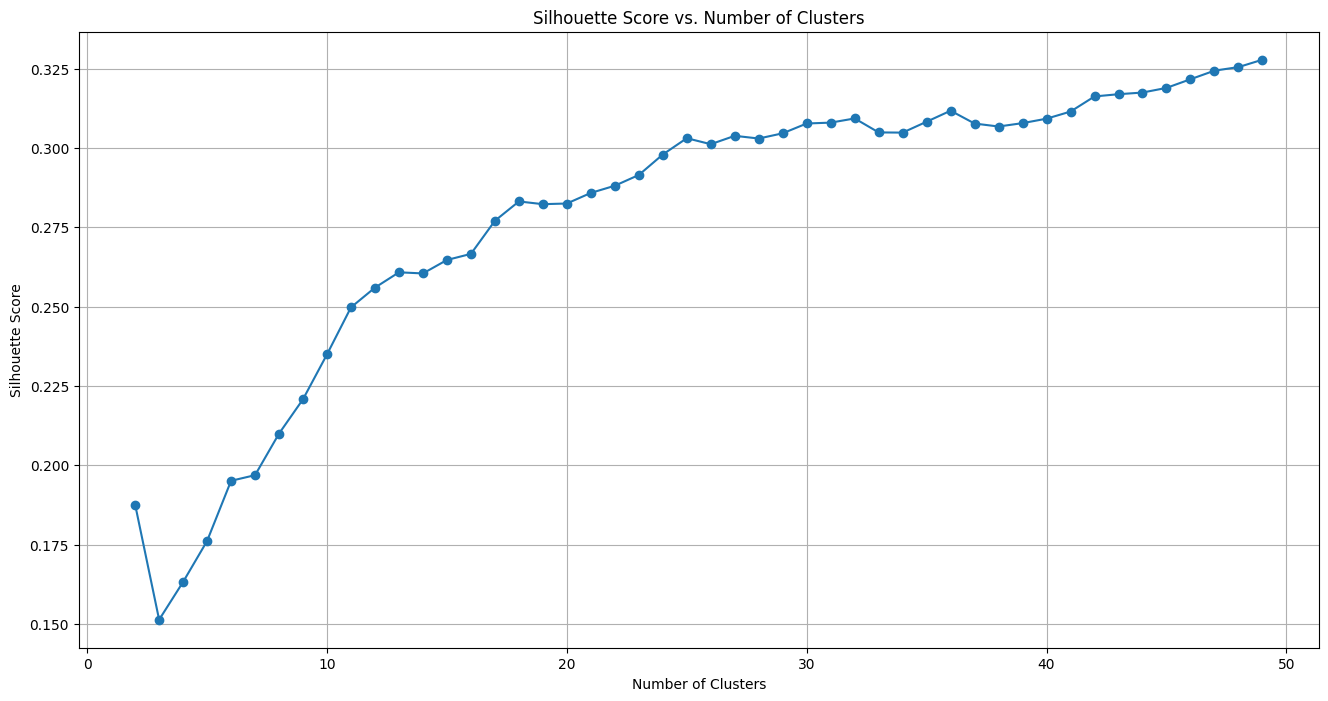

In [12]:
cluster_range = range(2, 50)
silhouette_scores = []

for n_clusters in cluster_range:
    labels = fcluster(linked, n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(city_profiles_standardized.transpose(), labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(16, 8))
plt.subplot(1, 1, 1)  # Adjusted for a single plot focus on silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

From the graph it looks like 10 or 11 clusters is best, since the rate of change starts to slow more dramatically.

Try to find "optimal" number of clusters using rate of change:

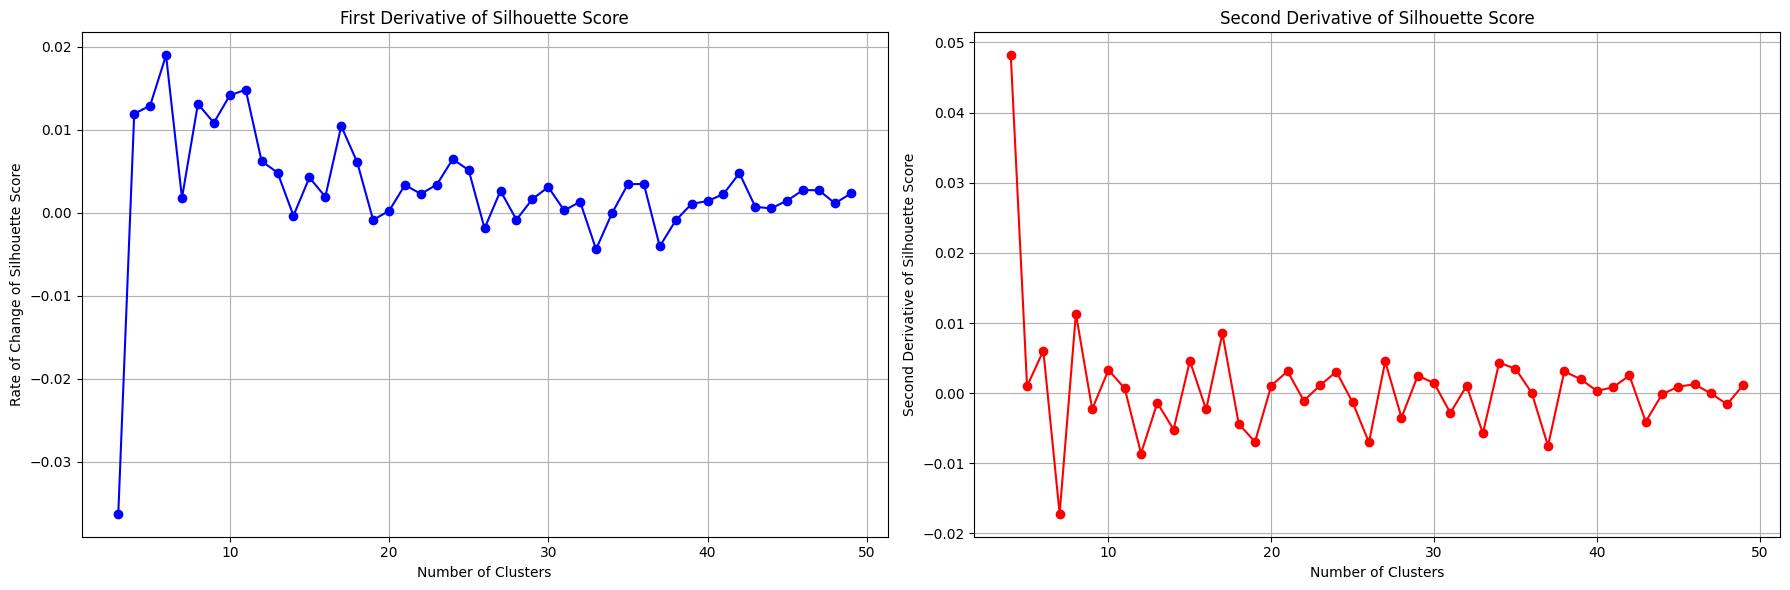

First decrease in rate of change starts at: 12 clusters


In [29]:
# Calculate the first derivative (rate of change) of the silhouette scores
first_derivative = np.diff(silhouette_scores) / np.diff(list(cluster_range))

# Calculate the second derivative
second_derivative = np.diff(first_derivative)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.plot(cluster_range[1:], first_derivative, marker='o', linestyle='-', color='blue')
plt.title('First Derivative of Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Rate of Change of Silhouette Score')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(cluster_range[2:], second_derivative, marker='o', linestyle='-', color='red')
plt.title('Second Derivative of Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Second Derivative of Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

# Trying to programmatically find the "elbow"
# Look for where the second derivative increases or the first derivative starts to decrease for the second time - just to be safe
n_clusters = 0
dec_count = 0
for i in range(1, len(second_derivative)):
    if second_derivative[i] > second_derivative[i - 1]:
        dec_count += 1
        if dec_count == 4: # Arbitrary, took looking at separation results below
            n_clusters = i + 3
            print(f"First decrease in rate of change starts at: {n_clusters} clusters")  # +3 due to diff calculation offset
            break


The plot agrees with our calculation - it looks like 7 is the optimal number of clusters. Let's continue.

In [32]:
agg_clustering = AgglomerativeClustering(n_clusters=12, linkage='ward')
agg_labels = agg_clustering.fit_predict(city_profiles_standardized.transpose())

# Correctly associate cluster labels with cities
cities = city_profiles_standardized.columns
city_cluster_map = pd.DataFrame({'City': cities, 'Cluster': agg_labels})

In [33]:
df_hierarchical = pd.merge(df, city_cluster_map, on='City', how='left').drop_duplicates(subset='City', keep='first')
df_hierarchical = df_hierarchical[['Country', 'NumericLatitude', 'NumericLongitude', 'Continent', 'kcc', 'City', 'Cluster']]

df_hierarchical = df_hierarchical.sort_values(by=['Cluster', 'City']).reset_index(drop=True)

outfile = 'Data_hierarchical.csv'
df_hierarchical.to_csv(f'{outfile}', index=False)

print(f'Exported clustered cities to {outfile}')

Exported clustered cities to Data_hierarchical.csv


#### Cluster visualizations

1. Unique Cities in each cluster
2. Unique Countries in each cluster
3. Proportion of Continents in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
4. Proportion of climates in each cluster relative to all data
   1. Bar graph with absolute abundance
   2. Heat map with relative abundance
5. For each cluster:
   1. Averaged AverageTemperature by Year & correlations
   2. AverageTemperature by Year & correlations
   3. Box & Whiskers plots to look at geographic spread (Latitude, Longitude)

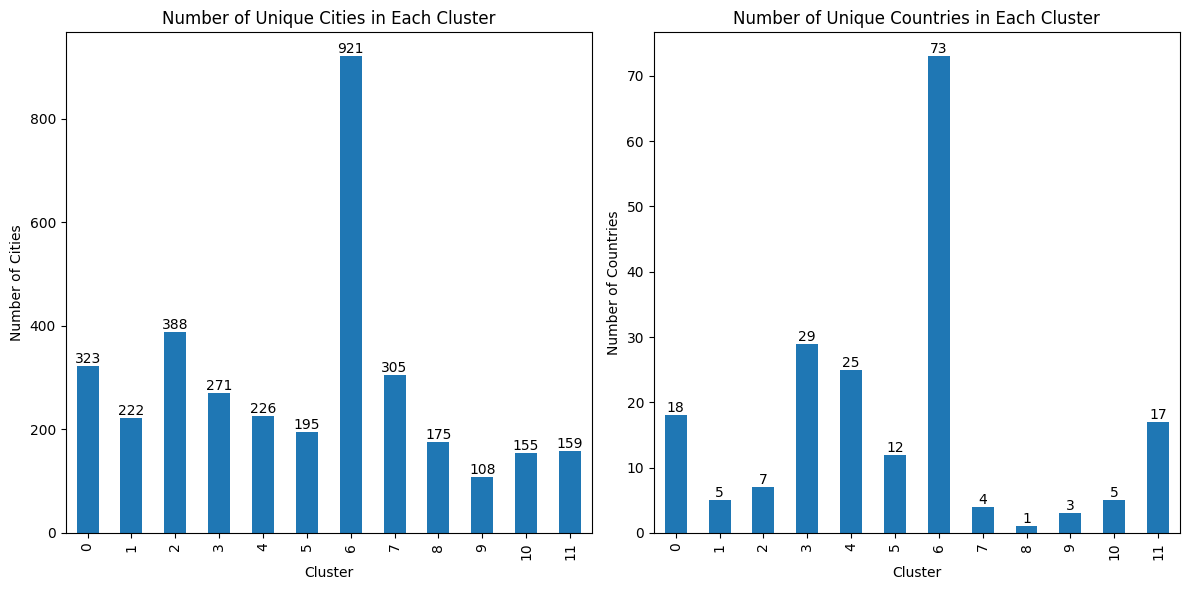

In [34]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
cities_per_cluster = df_hierarchical.groupby('Cluster')['City'].nunique()
cities_per_cluster.plot(kind='bar')
plt.title('Number of Unique Cities in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Cities')
for index, value in enumerate(cities_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.subplot(1, 2, 2)
countries_per_cluster = df_hierarchical.groupby('Cluster')['Country'].nunique()
countries_per_cluster.plot(kind='bar')
plt.title('Number of Unique Countries in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Countries')
for index, value in enumerate(countries_per_cluster):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.tight_layout()
plt.show()

Visualize each averaged cluster

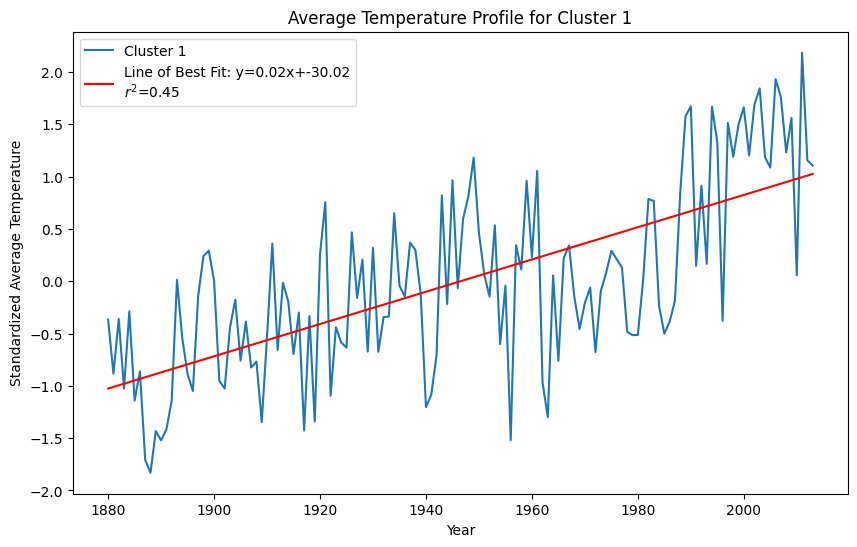

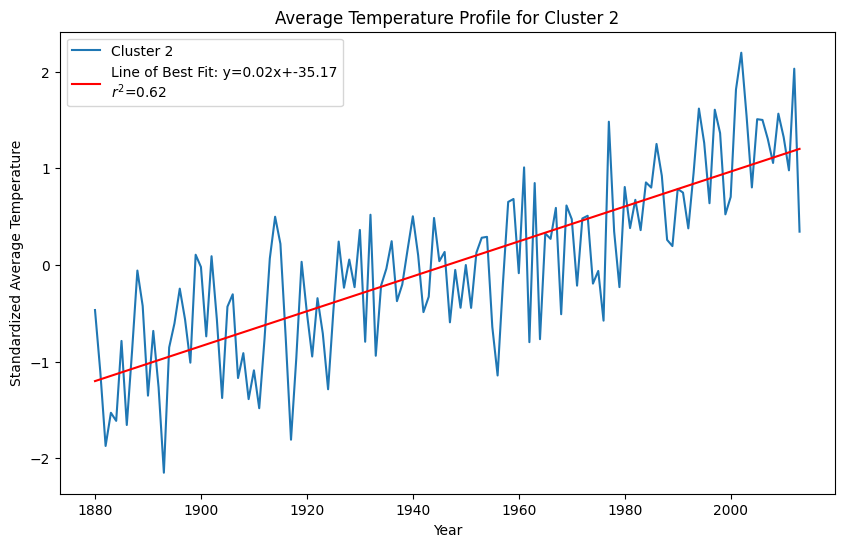

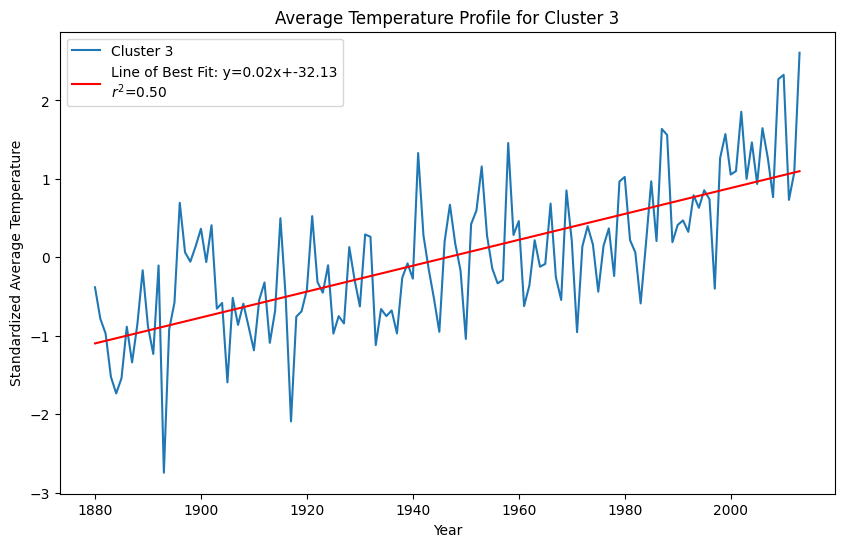

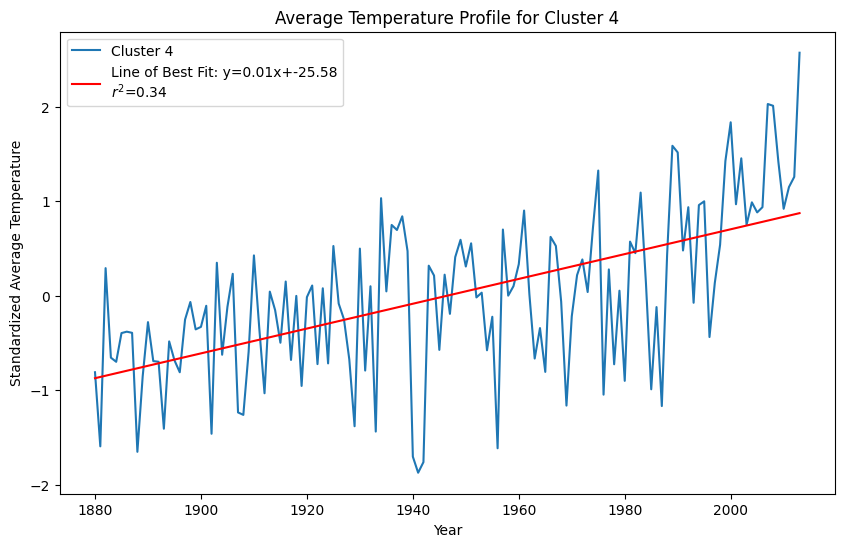

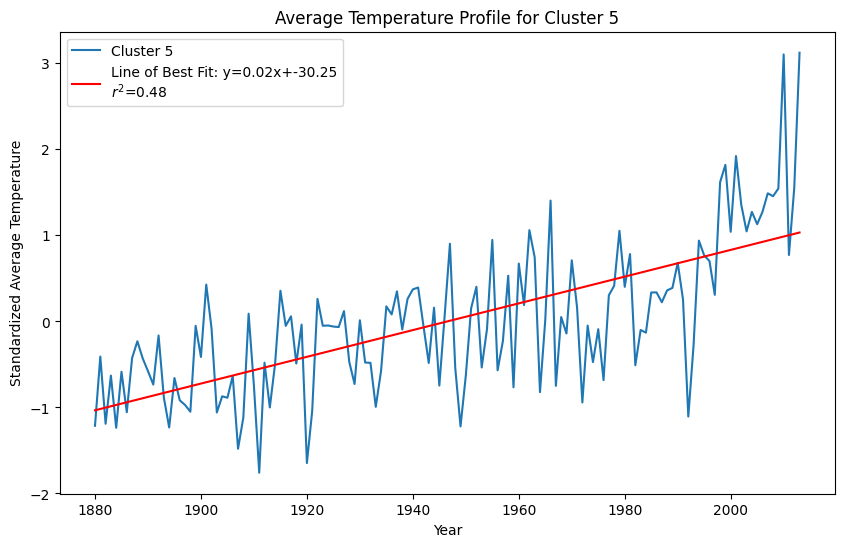

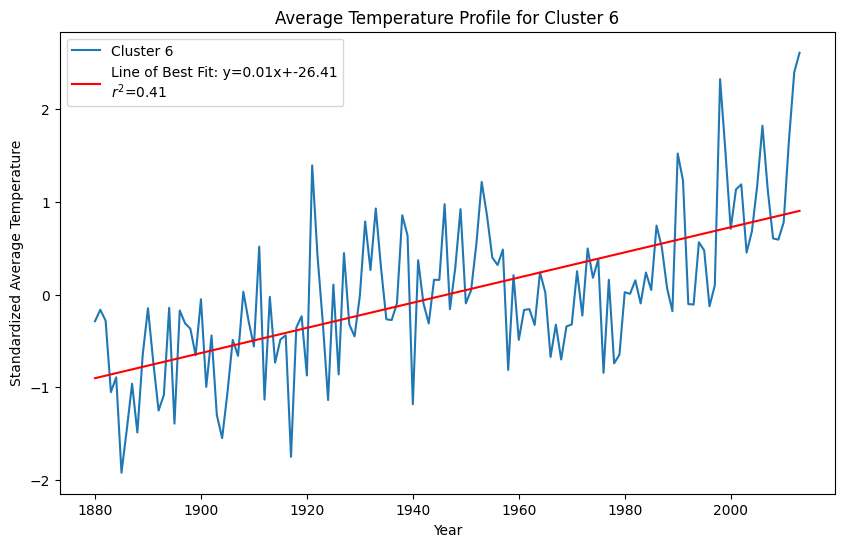

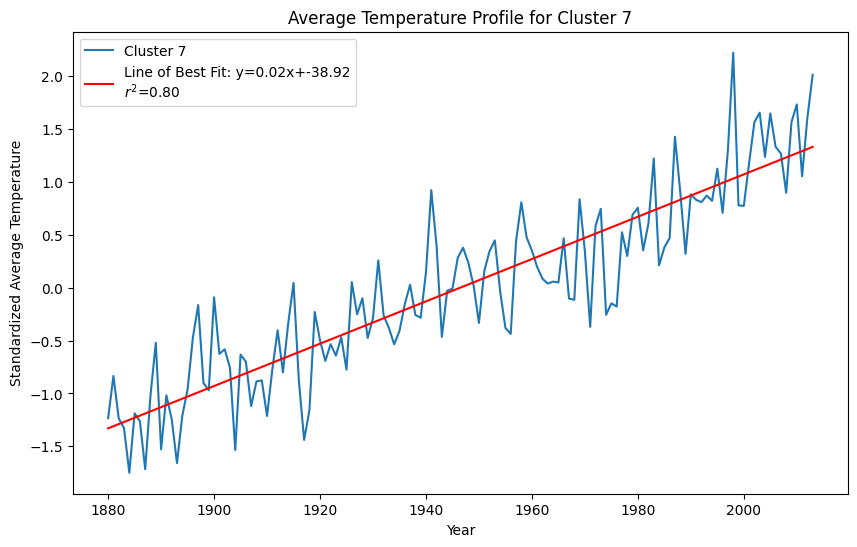

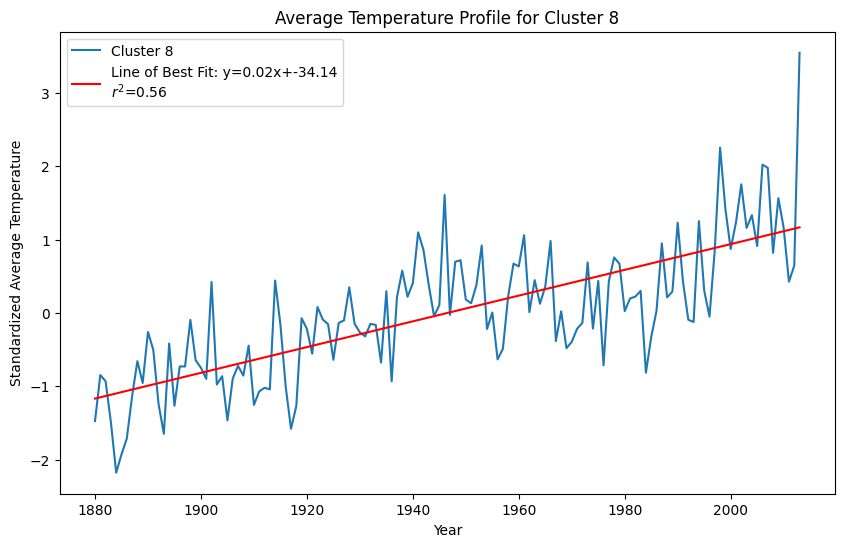

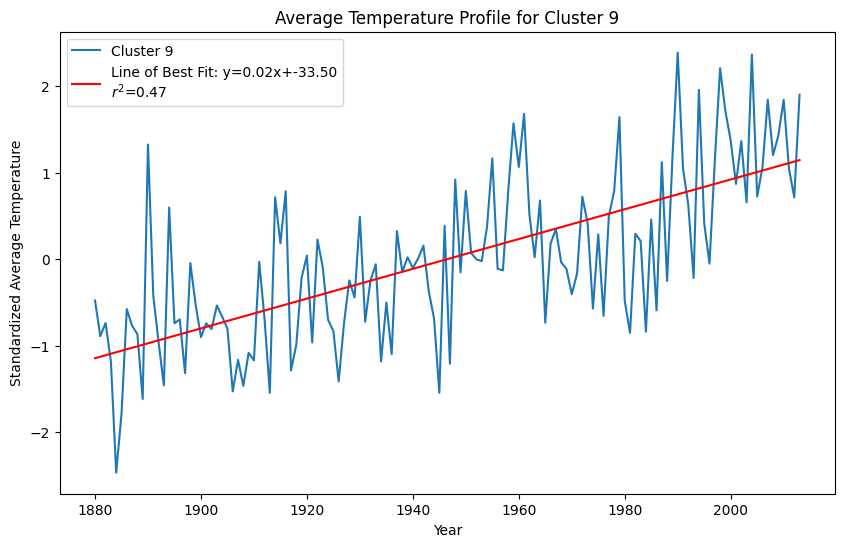

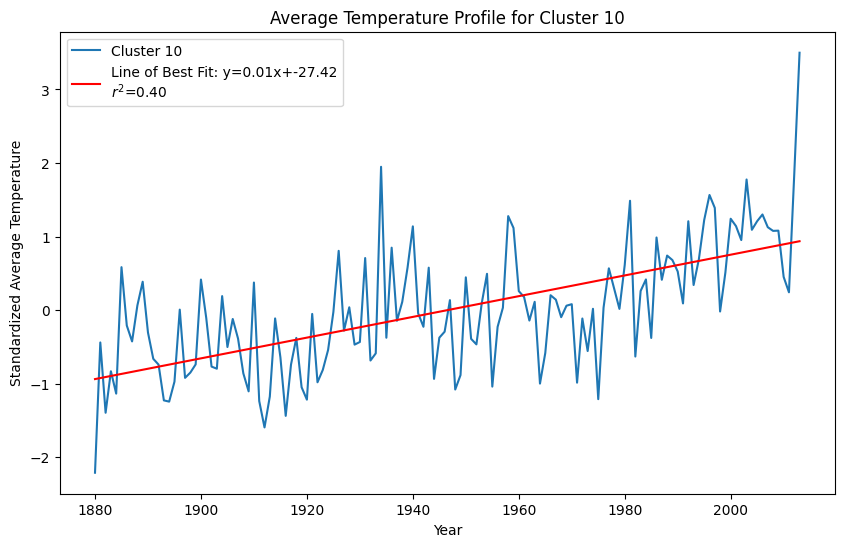

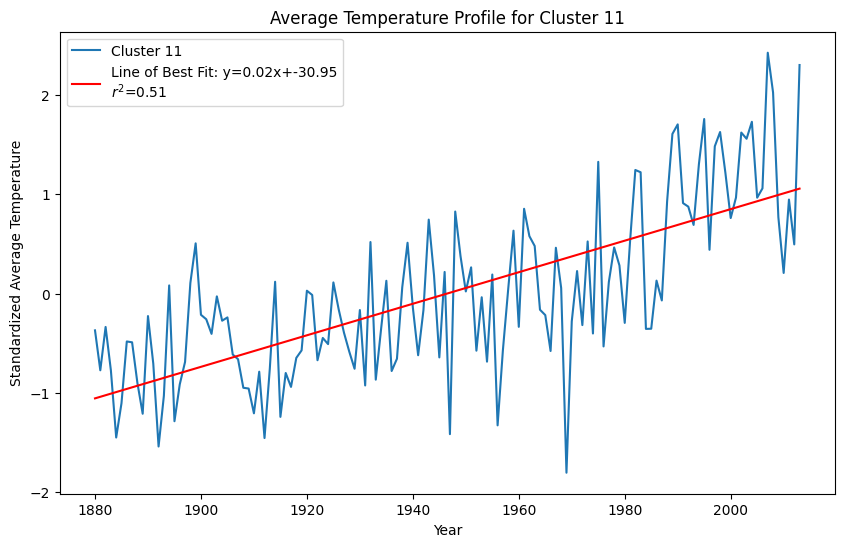

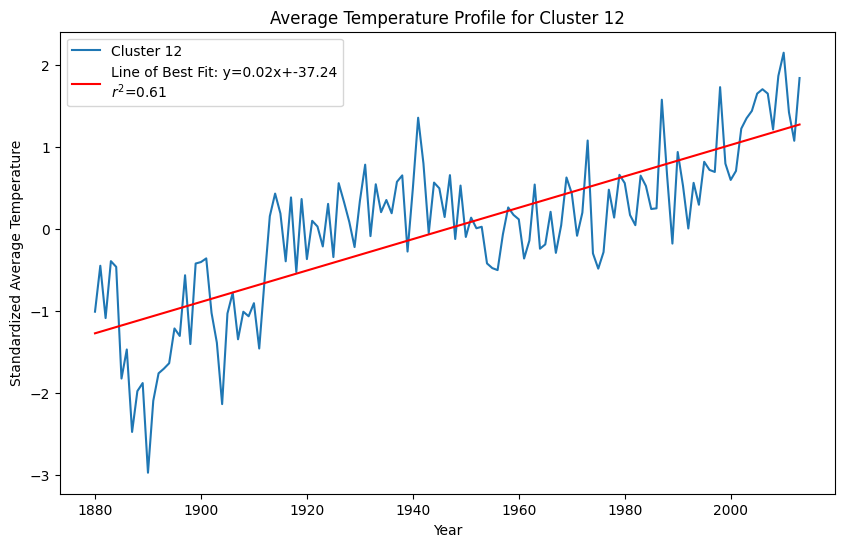

In [36]:
for cluster in range(n_clusters):
    # Extract cities belonging to the current cluster
    cluster_cities = city_cluster_map[city_cluster_map['Cluster'] == cluster]['City']
    cluster_profiles = city_profiles_standardized[cluster_cities]
    
    plt.figure(figsize=(10, 6))


    mean_profile = cluster_profiles.mean(axis=1)
    plt.plot(mean_profile.index, mean_profile.values, label=f'Cluster {cluster + 1}')

    # line of best fit
    slope, intercept, r_value, _, _ = linregress(mean_profile.index.astype(float), mean_profile.values)
    line = slope * mean_profile.index.astype(float) + intercept
    plt.plot(mean_profile.index, line, 'r', label=f'Line of Best Fit: y={slope:.2f}x+{intercept:.2f}\n$r^2$={r_value**2:.2f}')
    
    plt.title(f'Average Temperature Profile for Cluster {cluster + 1}')
    plt.xlabel('Year')
    plt.ylabel('Standardized Average Temperature')
    plt.legend()
    plt.show()

View clusters based on MDS

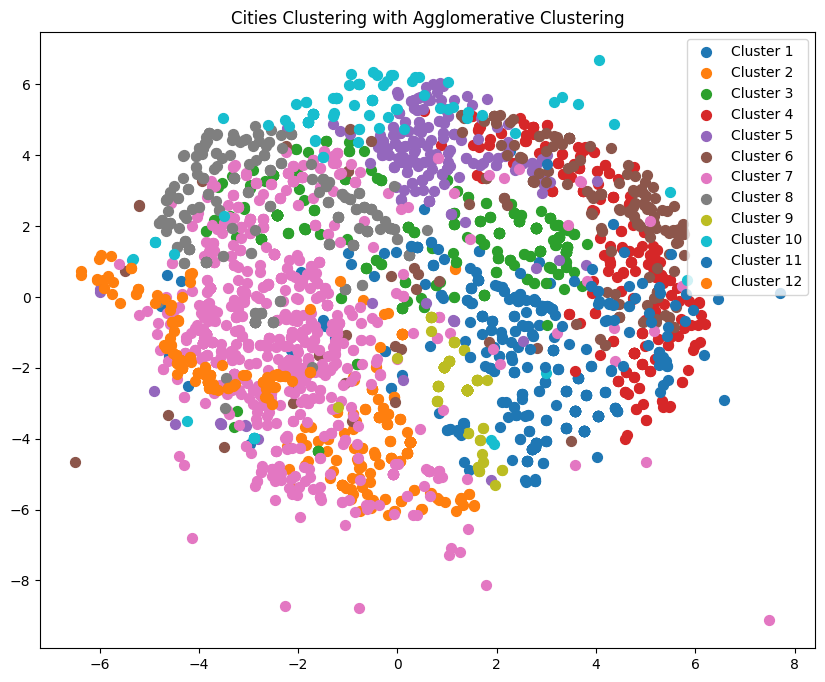

In [37]:
plt.figure(figsize=(10, 8))

# Scatter plot of the two dimensions, colored by cluster label
for i in range(n_clusters):
    # Select only data observations with cluster label == i
    cluster = matrix_cities[agg_labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], s=50, label=f'Cluster {i+1}')

plt.title('Cities Clustering with Agglomerative Clustering')
plt.legend()
plt.show()

Relative abundance of Continents for each cluster vs. unclustered data

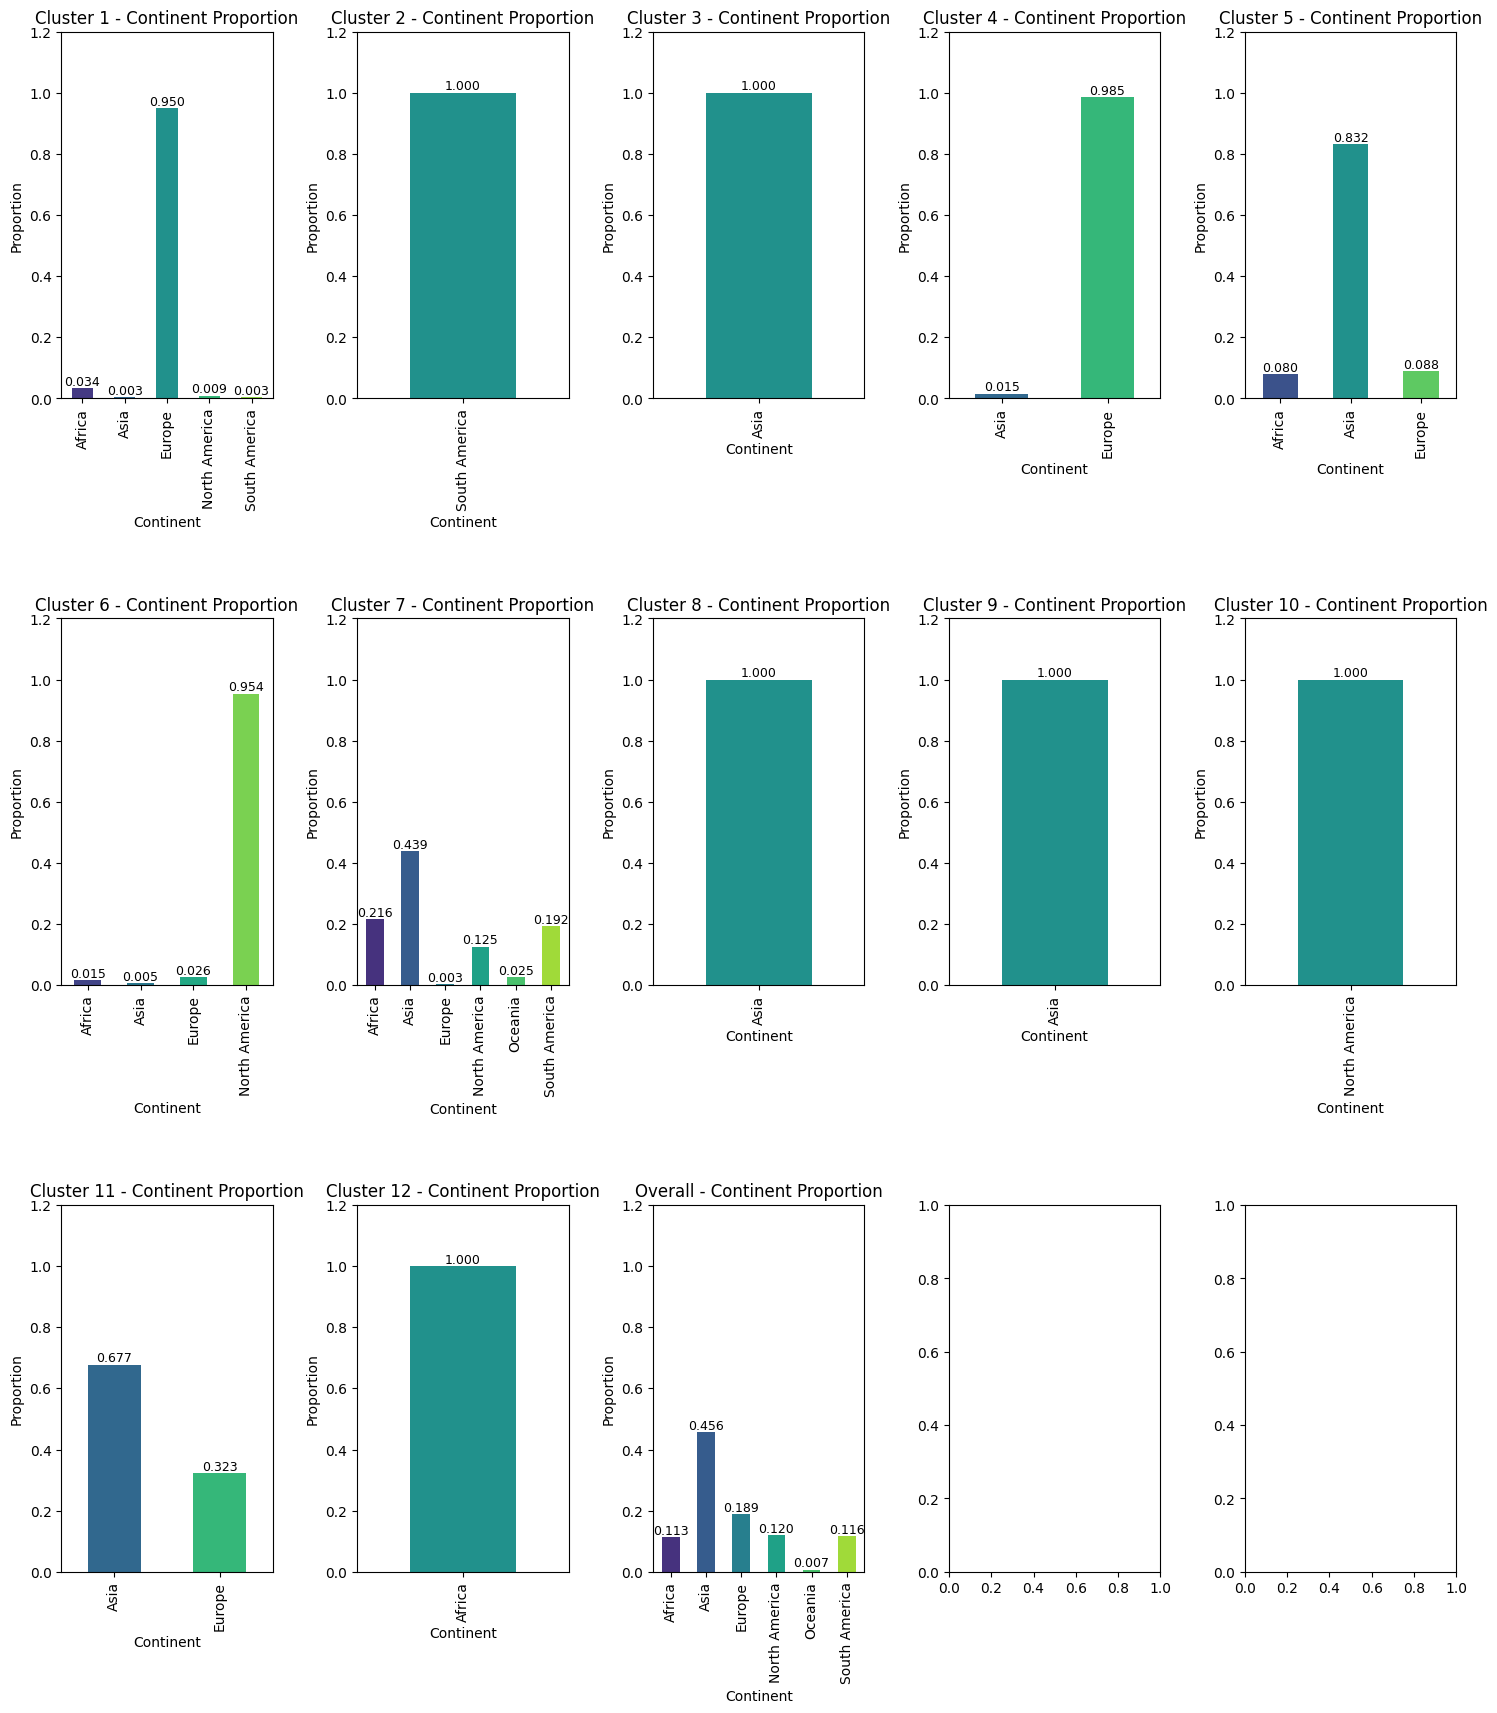

In [41]:
fig, axs = plt.subplots(3, 5, figsize=(18, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

def add_labels(ax, series):
    for index, value in enumerate(series):
        ax.text(index, value, f"{value:.3f}", ha='center', va='bottom', fontsize=9, color='black')

for i in range(n_clusters):
    ax = axs.flat[i]
    cluster_continent_abundance = df_merged[df_merged['Cluster'] == i]['Continent'].value_counts(normalize=True).sort_index()
    cluster_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_continent_abundance)))
    ax.set_title(f'Cluster {i+1} - Continent Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1.2)
    add_labels(ax, cluster_continent_abundance)

ax = axs.flat[n_clusters]
overall_continent_abundance = df['Continent'].value_counts(normalize=True).sort_index()
overall_continent_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_continent_abundance)))
ax.set_title('Overall - Continent Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1.2)
add_labels(ax, overall_continent_abundance)

Relative abundance of Koppen Climate Classifications (kccs) for each cluster vs. unclustered data

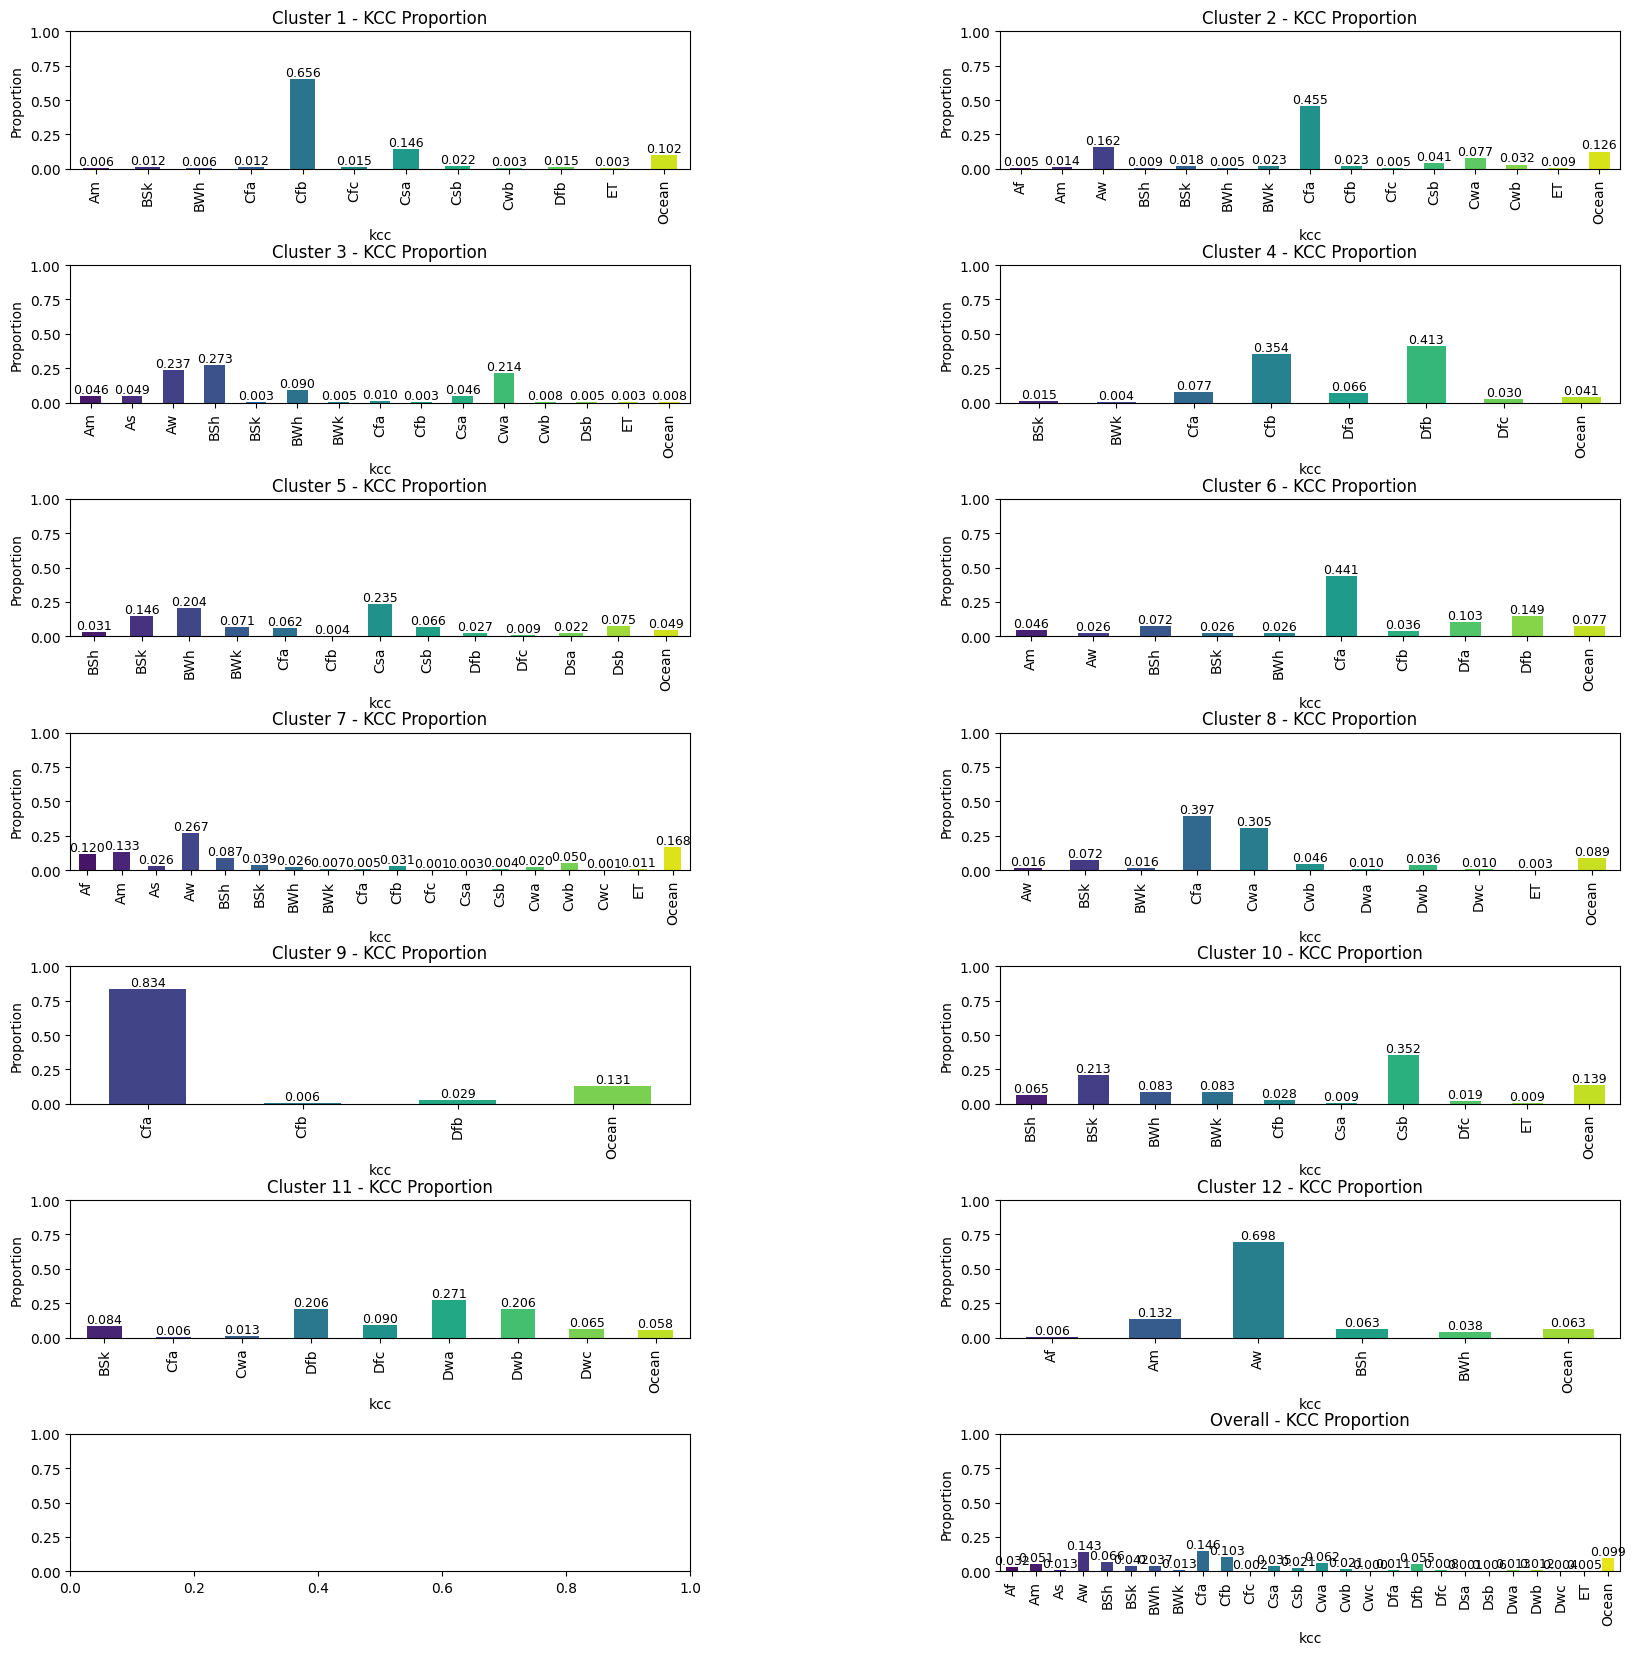

In [46]:
fig, axs = plt.subplots(7, 2, figsize=(20, 20))
fig.subplots_adjust(hspace=0.7, wspace=0.5)

for i in range(n_clusters):
    ax = axs.flat[i]
    cluster_kcc_abundance = df_merged[df_merged['Cluster'] == i]['kcc'].value_counts(normalize=True).sort_index()
    cluster_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(cluster_kcc_abundance)))
    ax.set_title(f'Cluster {i+1} - KCC Proportion')
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 1)
    add_labels(ax, cluster_kcc_abundance)


ax = axs.flat[-1]
overall_kcc_abundance = df['kcc'].value_counts(normalize=True).sort_index()
overall_kcc_abundance.plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(overall_kcc_abundance)))
ax.set_title('Overall - KCC Proportion')
ax.set_ylabel('Proportion')
ax.set_ylim(0, 1)
add_labels(ax, overall_kcc_abundance)

Visualize relative abundances of continent and kccs as a heatmap

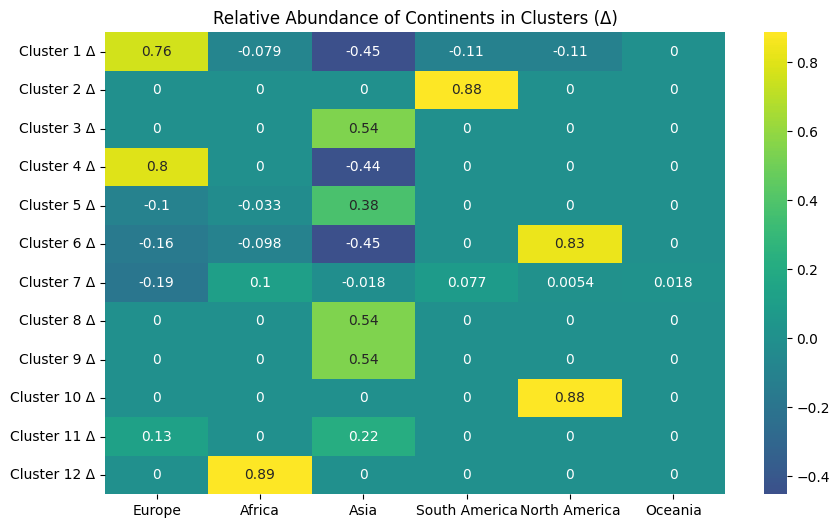

In [54]:
continents = df_hierarchical['Continent'].unique()
overall_continent_counts = df_hierarchical['Continent'].value_counts(normalize=True)

deltas = pd.DataFrame(index=continents)

for i in range(n_clusters):
    cluster_data = df_hierarchical[df_hierarchical['Cluster'] == i]
    continent_counts = cluster_data['Continent'].value_counts(normalize=True)
    deltas[f'Cluster {i+1} Δ'] = continent_counts - overall_continent_counts
deltas = deltas.transpose()
deltas.fillna(0, inplace=True)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(deltas, annot=True, cmap="viridis", center=0)
plt.title('Relative Abundance of Continents in Clusters (Δ)')
plt.show()

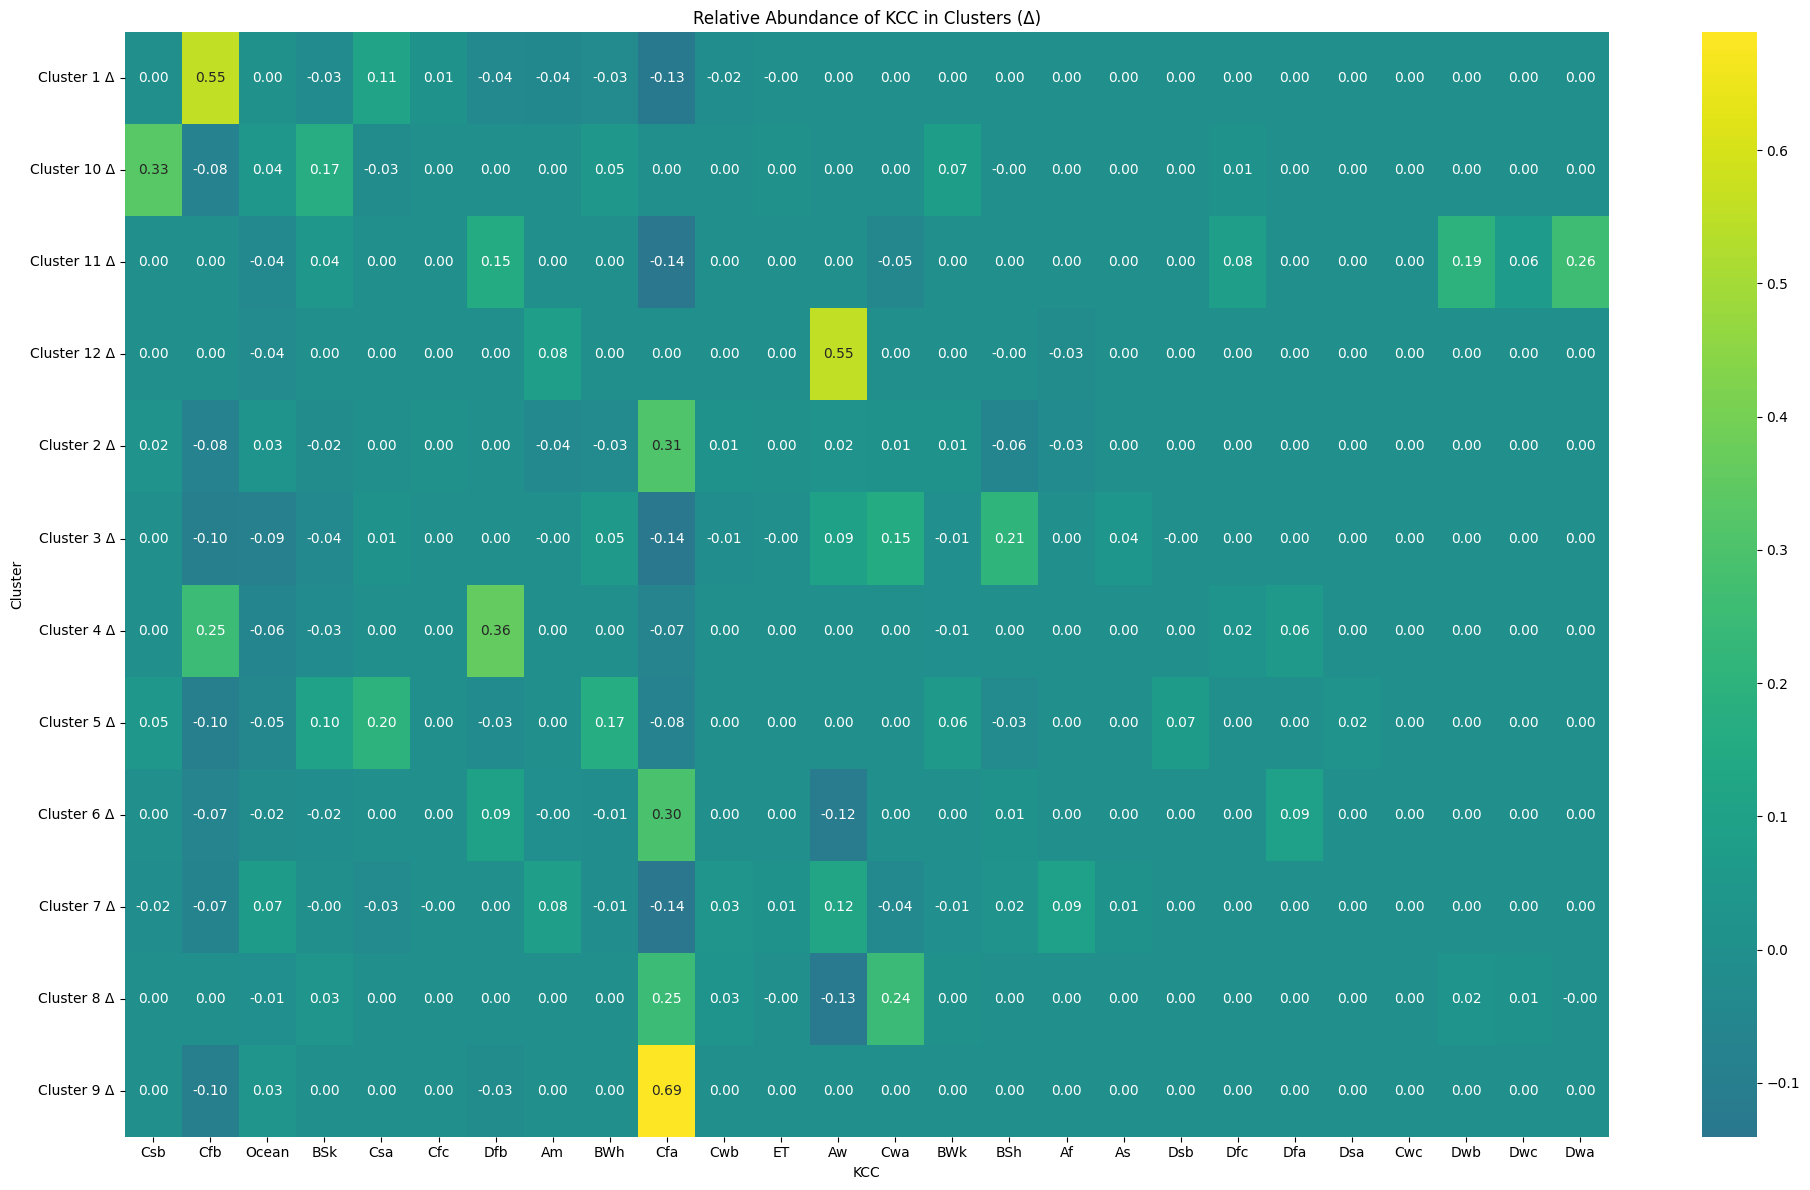

In [55]:
climates = df_hierarchical['kcc'].unique()
overall_climate_counts = df_hierarchical['kcc'].value_counts(normalize=True)

# Initialize a DataFrame to store the deltas
climate_deltas = pd.DataFrame(index=climates)

# Calculate deltas for each cluster
for i in range(n_clusters):
    cluster_data = df_hierarchical[df_hierarchical['Cluster'] == i]
    climate_counts = cluster_data['kcc'].value_counts(normalize=True)
    climate_deltas[f'Cluster {i+1} Δ'] = climate_counts - overall_climate_counts

# Transpose the DataFrame for easier plotting with seaborn
climate_deltas = climate_deltas.transpose()

# Replace NaN values with 0 (indicating no difference for missing climates in some clusters)
climate_deltas.fillna(0, inplace=True)

# Sort index for a cleaner look if necessary
climate_deltas.sort_index(inplace=True)

# Plot the heatmap
plt.figure(figsize=(20, 12))
sns.heatmap(climate_deltas, annot=True, fmt=".2f", cmap="viridis", center=0)
plt.title('Relative Abundance of KCC in Clusters (Δ)')
plt.ylabel('Cluster')
plt.xlabel('KCC')
plt.tight_layout()
plt.show()

Geographic spread of clusters:

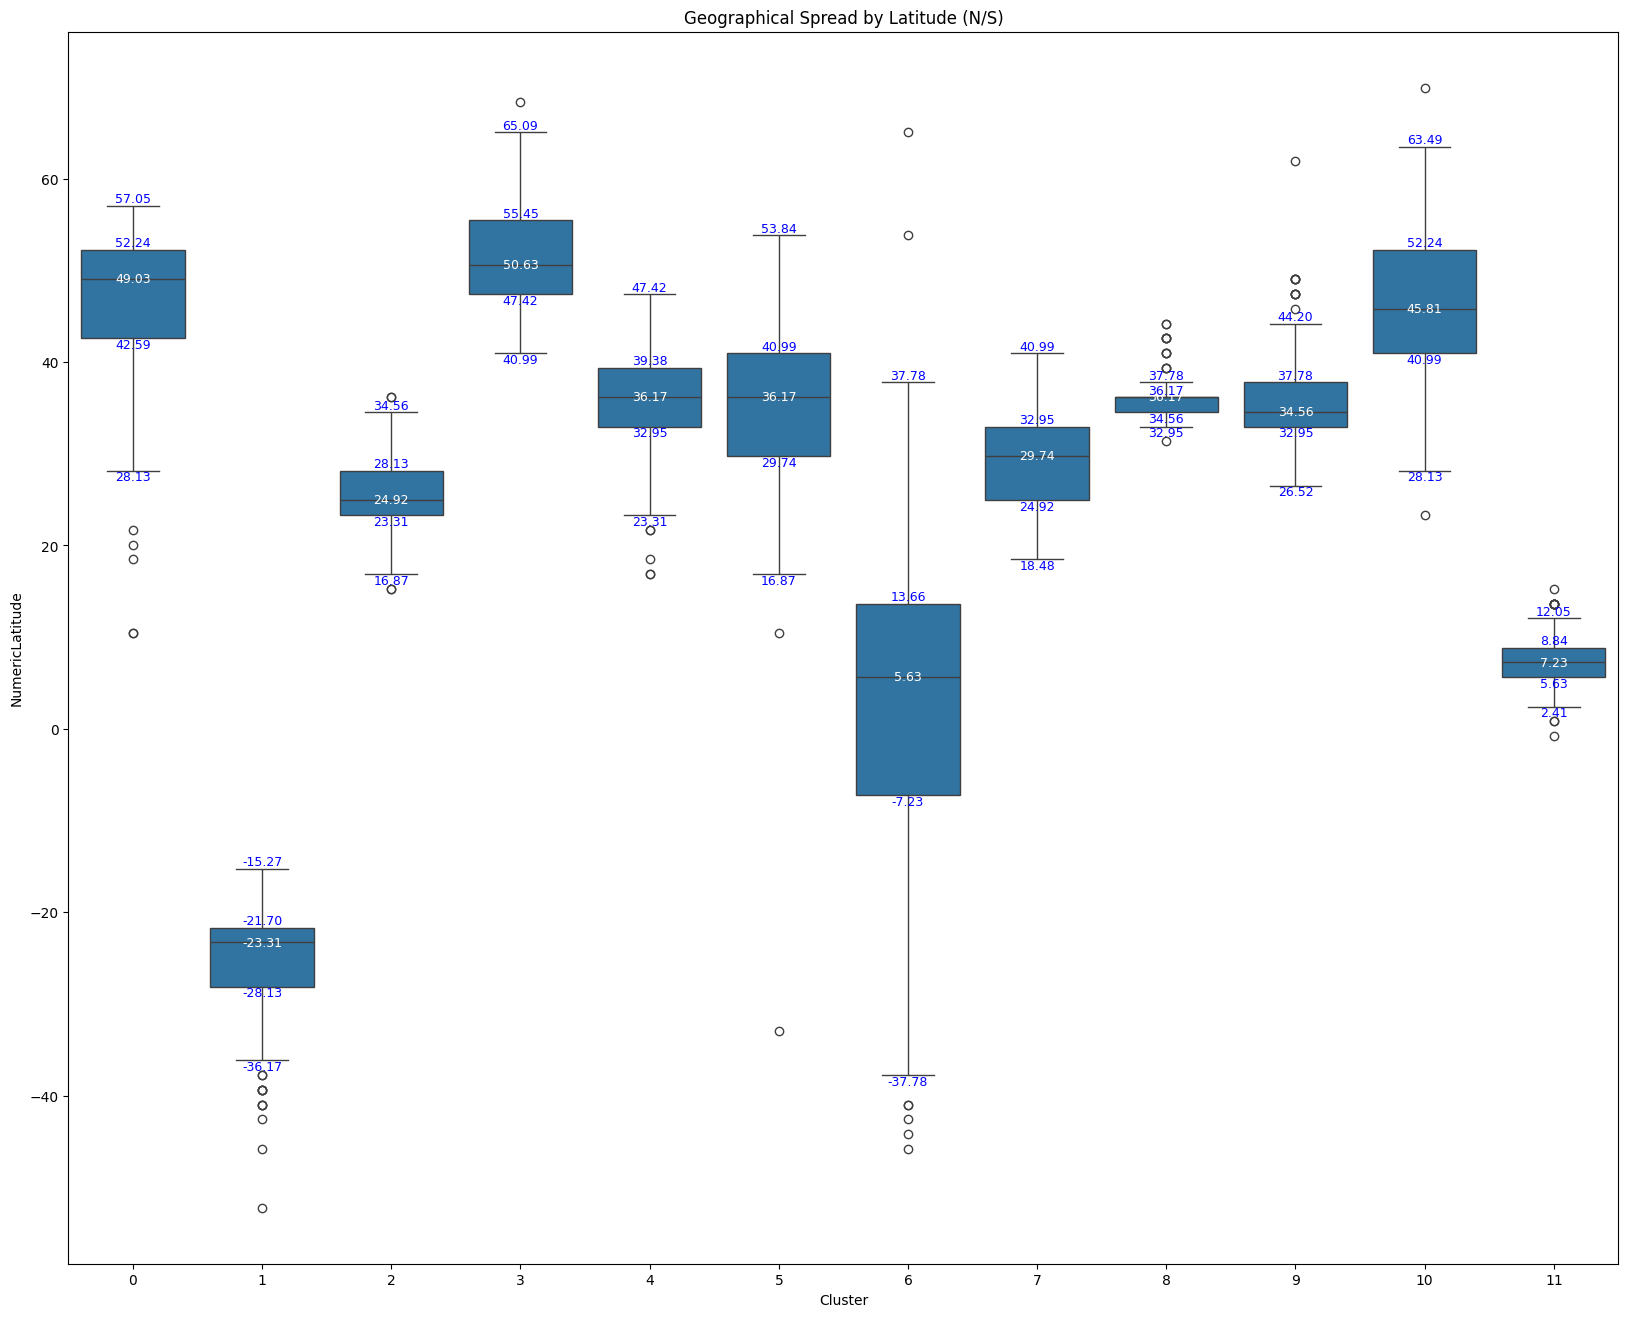

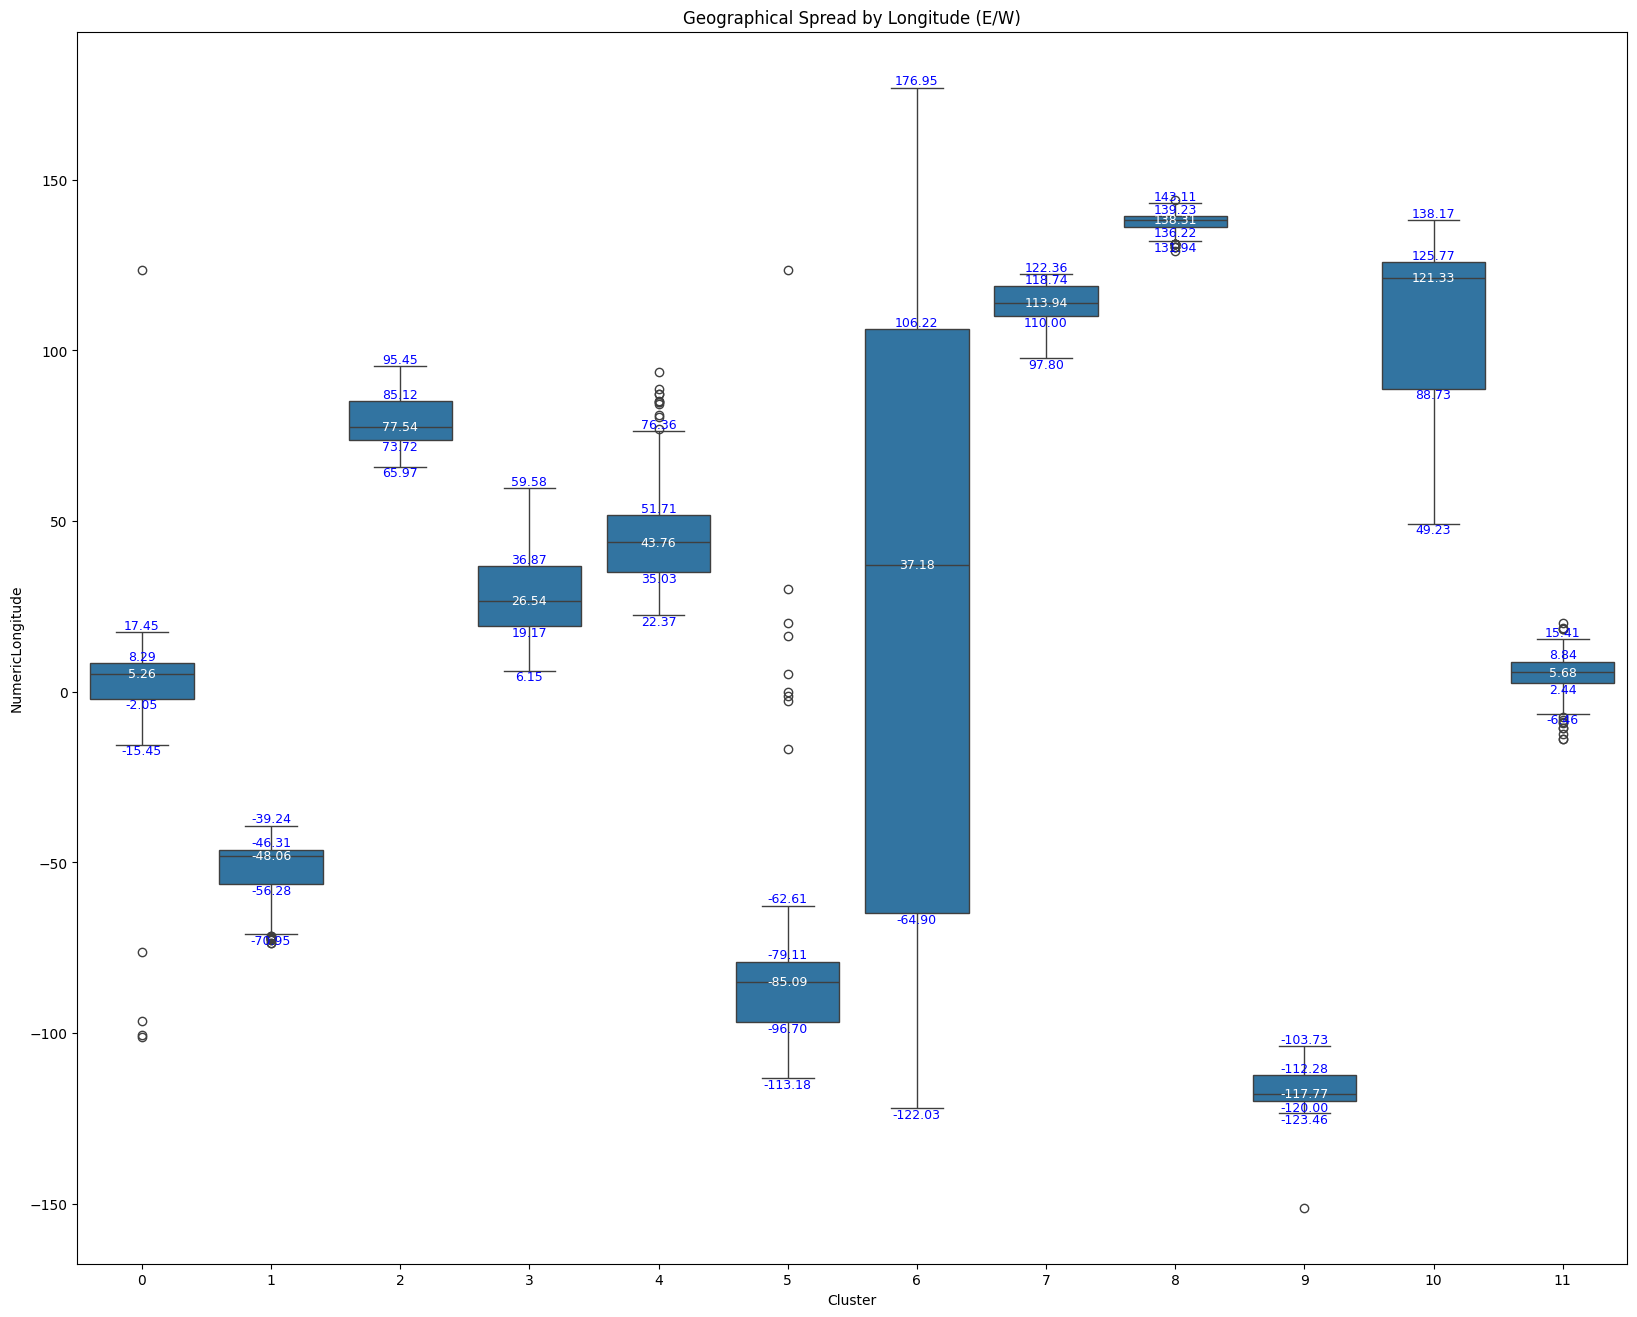

In [57]:
# Latitude
plt.figure(figsize=(20, 16))
sns.boxplot(x='Cluster', y='NumericLatitude', data=df_hierarchical)

num_clusters = df_hierarchical['Cluster'].nunique()
for i in range(num_clusters):
    cluster_latitudes = df_hierarchical[df_hierarchical['Cluster'] == i]['NumericLatitude']
    percentiles = np.percentile(cluster_latitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_latitudes[cluster_latitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_latitudes[cluster_latitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Latitude (N/S)')
plt.ylabel('NumericLatitude')
plt.xlabel('Cluster')
plt.show()

# Longitude
plt.figure(figsize=(20, 16))
sns.boxplot(x='Cluster', y='NumericLongitude', data=df_hierarchical)
for i in range(num_clusters):
    cluster_Longitudes = df_hierarchical[df_hierarchical['Cluster'] == i]['NumericLongitude']
    percentiles = np.percentile(cluster_Longitudes, [25, 50, 75])  # Q1, Median, Q3
    lower_whisker = np.min(cluster_Longitudes[cluster_Longitudes >= percentiles[0] - 1.5*(percentiles[2]-percentiles[0])])
    upper_whisker = np.max(cluster_Longitudes[cluster_Longitudes <= percentiles[2] + 1.5*(percentiles[2]-percentiles[0])])
    
    # Placing text annotations for percentiles
    plt.text(i, lower_whisker, f'{lower_whisker:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[0], f'{percentiles[0]:.2f}', ha='center', va='top', fontsize=9, color='blue')
    plt.text(i, percentiles[1], f'{percentiles[1]:.2f}', ha='center', va='center', fontsize=9, color='white')
    plt.text(i, percentiles[2], f'{percentiles[2]:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    plt.text(i, upper_whisker, f'{upper_whisker:.2f}', ha='center', va='bottom', fontsize=9, color='blue')

plt.title('Geographical Spread by Longitude (E/W)')
plt.ylabel('NumericLongitude')
plt.xlabel('Cluster')
plt.show()